# Model development


## Policy

We assume that $A = \{a_{0}, a_{1}\}$, we further define $a_{0}$ as "deny credit" and $a_{1}$ as "offer credit". We also know from the project text that the utility function is assumed to be linear. This implies that among $E(utility|a_{i})$ and $E(utility|a_{j})$, we will always choose action $a_{i}$ over action $a_{j}$ if $E(utility|a_{i}) > E(utility|a_{j})$ adapted from (Dimitrakakis, 2020, p. 48). We will "blindly" choose the action that maximizes expected utility.

## Utility function

There are two possible actions that we could perform: $\{a_{0}, a_{1}\}$. We also have the following rewards, which are defined as possible outcomes for the bank (Dimitrakakis, 2020, p. 47). In our case these rewards are $\{-m, 0, m((1 + r)^{n} - 1)\}$. Further there are two possible actions for the bank when it comes to deciding for each new customer if they will be granted credit.

Further, we will use the definition of expected utility
$$
E[U|a_{t} = a] = \sum_{r} U(r)Pr(r|a_{t} = a)
$$
adapted from (Dimitrakakis, 2020, p. 48). This will be used for each action to calculate its expected utility. We can further define the rewards as $r_{0} =$ "the debtor defaults" and $r_{1} =$ "the debtor does not default". If we use the assumption that the utility function is linear, we can say that $U(r)$ is proportional to $r$.

### Grant credit

If we decide to grant credit ($a_{t} = 1 $) we have the following expected utility considering the rewards above:
$$
E[U|a_{t} = 1] = U(r = r_{0})Pr(r = r_{0}|a_{t} = 1) + U(r = r_{1})Pr(r = r_{1}|a_{t} = 1) 
$$
which becomes
$$
E[U|a_{t} = 1] = -m \cdot Pr(r = r_{0}|a_{t} = 1) + m((1 + r)^{n} - 1) \cdot Pr(r = r_{1}|a_{t} = 1)
$$
In our code, we have defined $Pr(r = r_{1}|a_{t} = 1)$ as the variable "p_c" and $Pr(r = r_{0}|a_{t} = 1)$ as 1-"p_c".

### Do not grant credit

If we decide not to grant credit ($a_{t} = 0 $).

$$
E[U|a_{t} = 0] = 0 \cdot Pr(r = r_{0}|a_{t} = 0) + 0 \cdot Pr(r = r_{1}|a_{t} = 0) = 0
$$



## Expected utility

If we do not give out the loan, the expected utility is $0$, as there is nothing to gain or loose. If we give a loan there are two possible outcomes; either they are able to pay it back with interest, or we loose the investment $m$. We can therefor write the expected utility if we give a loan as:
$$E(U(x) | a = a_\text{loan}) = m[(1+r)^n - 1] p(x_1) - m p(x_2),$$
where $p(x_1)$ is the probability of paying back the loan with interest and $p(x_2)$ is the probability of loosing the interest.

In [1]:
def expected_utility(self, x, action):
    """Calculate expected utility using the decision maker model.

    Args:
        x: A new observation.
        action: Whether or not to grant the loan.
    
    Returns:
        The expected utility of the decision maker.
    """
    if action == 0:
        return 0

    r = self.rate
    p_c = self.predict_proba(x)

    # duration in months
    n = x['duration']
    # amount
    m = x['amount']

    e_x = p_c * m * ((1 + r) ** n - 1) + (1 - p_c) * (-m)
    return e_x

## Fitting a model

We chose to use a logistic regression model. It predicts the probability of a binary categorical variable beeing 1. A fresh random state is also given to the model for reproducable results.

In [2]:
def fit(self, X, y):
    """Fits a logistic regression model.

    Args:
        X: The covariates of the data set.
        y: The response variable from the data set.

    Notes:
        Using logistic regression, adapted from 
        https://scikit-learn.org/stable/modules/generated/sklearn.
        linear_model.LogisticRegression.html
    """
    self.data = [X, y]

    log_reg_object = LogisticRegression(random_state=1, max_iter=2000)
    self.model = log_reg_object.fit(X, y)

def predict_proba(self, x):
    """Predicts the probability for [0,1] given a new observation given the 
    model.

    Args:
        x: A new, independent observation.
    Returns:
        The prediction for class 1 given as the second element in the
        probability array returned from the model.
    """
    x = self._reshape(x)
    return self.model.predict_proba(x)[0][1]

def _reshape(self, x):
    """Reshapes Pandas Seris to a row vector.

    Args:
        x: Pandas Series.

    Returns:
        A ndarray as a row vector.
    """
    return x.values.reshape((1, len(x)))

When reading the data we one hot encode all the catagorical variables which means that they loose the information in the order. This could be fixed by instead giving them an integer value, but then we assume a linear relationship between the order of the categories.

## Best action

The best action is the action that gives the highest utility. In the event of the utilities beeing equal, we chose to not give a loan. Because of the linear utility of the investor it does not matter what we do in this situation, but we figured it is better to not accept unnecessary variability.

In [3]:
def get_best_action(self, x):
    """Gets the best action defined as the action that maximizes utility.

    Args:
        x: A new observation.
    Returns:
        Best action based on maximizing utility.
    """
    expected_utility_give_loan = self.expected_utility(x, 1)
    expected_utility_no_loan = self.expected_utility(x, 0)

    if expected_utility_give_loan > expected_utility_no_loan:
        return 1
    else:
        return 0

# Testing the model against random model

In [4]:
%matplotlib inline

import random_banker
import group1_banker
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(24092020)

features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign', 'repaid']

data_raw = pd.read_csv("german.data",
                 delim_whitespace=True,
                 names=features)
data_raw.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking account balance  1000 non-null   object
 1   duration                  1000 non-null   int64 
 2   credit history            1000 non-null   object
 3   purpose                   1000 non-null   object
 4   amount                    1000 non-null   int64 
 5   savings                   1000 non-null   object
 6   employment                1000 non-null   object
 7   installment               1000 non-null   int64 
 8   marital status            1000 non-null   object
 9   other debtors             1000 non-null   object
 10  residence time            1000 non-null   int64 
 11  property                  1000 non-null   object
 12  age                       1000 non-null   int64 
 13  other installments        1000 non-null   object
 14  housing    

## Transforming the data

In [5]:
numeric_variables = ['duration', 'age', 'residence time', 'installment',
             'amount', 'persons', 'credits']
data = data_raw[numeric_variables]

# Mapping the response to 0 and 1
data["repaid"] = data_raw["repaid"].map({1:1, 2:0})

In [6]:
# Create dummy variables for all the catagorical variables
not_dummy_names = numeric_variables + ["repaid"]
dummy_names = [x not in not_dummy_names for x in features]
dummies = pd.get_dummies(data_raw.iloc[:,dummy_names], drop_first=True)
data = data.join(dummies)

## Testing decision makers

In [7]:
def utility_from_obs(predicted_decision, true_decision, amount, duration, interest_rate):
    """Calculates utility from a single observation.

    Args:
        predicted_decision: the model's best action
        true_decision: if the observation repaid or not
        amount: the lending amount
        duration: the number of periods
        interest_rate: the interest rate of the loan

    Returns:
        The utility from the single observation given our action.
    """
    if predicted_decision == 1:
        if true_decision == 1:
            return amount*((1 + interest_rate)**duration - 1)
        else:
            return -amount
    else:
        return 0

In [8]:
def utility_from_test_set(X, y, decision_maker, interest_rate):
    """Calculates total utility from a given test set.

    Args:
        X: the covariates of the test set
        y: the response variable of the test set
        decision_maker: the decision maker to use in order to calculate utility
        interest_rate: the interest rate to use when calculating utility

    Returns:
        The sum of utility from the test set and the sum of utility divided by
        total amount.
    """

    num_obs = len(X)
    obs_utility = np.zeros(num_obs)
    obs_amount = np.zeros_like(obs_utility)

    for new_obs in range(num_obs):
        predicted_decision = decision_maker.get_best_action(X.iloc[new_obs])
        true_decision = y.iloc[new_obs]

        amount = X['amount'].iloc[new_obs]
        duration = X['duration'].iloc[new_obs]

        obs_utility[new_obs] = utility_from_obs(
            predicted_decision, true_decision, amount, duration, interest_rate)
        obs_amount[new_obs] = amount

    return np.sum(obs_utility), np.sum(obs_utility)/np.sum(obs_amount)

In [9]:
def compare_decision_makers(num_of_tests, response, interest_rate):
    """Tests the random banker against our group1 banker.

    Args:
        num_of_tests: the number of tests to run
        response: the name of the response variable
        interest_rate: the interest rate to use when calculating utility
    """
    bank_utility_random = np.zeros(num_of_tests)
    bank_investment_random = np.zeros_like(bank_utility_random)
    bank_utility_group1 = np.zeros(num_of_tests)
    bank_investment_group1 = np.zeros_like(bank_utility_group1)

    results = {}

    # decision makers
    r_banker = random_banker.RandomBanker()
    r_banker.set_interest_rate(interest_rate)
    n_banker = group1_banker.Group1Banker()
    n_banker.set_interest_rate(interest_rate)

    # get data
    X = data
    covariates = X.columns[X.columns != response]

    for i in range(num_of_tests):
        X_train, X_test, y_train, y_test = train_test_split(
            X[covariates], X[response], test_size=0.2)

        # fit models
        r_banker.fit(X_train, y_train)
        n_banker.fit(X_train, y_train)

        bank_utility_random[i], bank_investment_random[i] = utility_from_test_set(
            X_test, y_test, r_banker, interest_rate)
        bank_utility_group1[i], bank_investment_group1[i] = utility_from_test_set(
            X_test, y_test, n_banker, interest_rate)

    results["utility_random_banker"] = bank_utility_random
    results["investment_random_banker"] = bank_investment_random
    results["utility_group1_banker"] = bank_utility_group1
    results["investment_group1_banker"] = bank_investment_group1

    return results
    


In [10]:
%%time
response = 'repaid'
results = pd.DataFrame(compare_decision_makers(100, response, 0.05))

CPU times: user 3min 5s, sys: 3min 22s, total: 6min 28s
Wall time: 60 s


In [11]:
results.describe()

,utility_random_banker,investment_random_banker,utility_group1_banker,investment_group1_banker
count,1.000000e+02,100.000000,1.000000e+02,100.000000
mean,5.922753e+05,0.913618,1.179659e+06,1.824227
std,1.995408e+05,0.296520,2.853486e+05,0.421368
min,1.715205e+05,0.270745,6.316046e+05,1.032309
25%,4.595768e+05,0.692373,9.990432e+05,1.515746
50%,5.880903e+05,0.913637,1.168483e+06,1.801856
75%,7.179540e+05,1.119127,1.347021e+06,2.076810
max,1.191101e+06,1.889368,2.134631e+06,3.049516


Text(0, 0.5, &#39;Density&#39;)

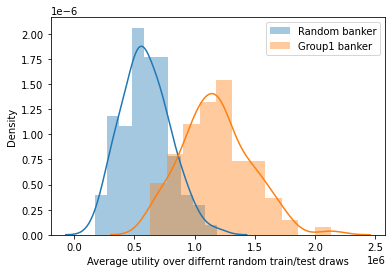

In [12]:
sns.distplot(results["utility_random_banker"], label="Random banker")
sns.distplot(results["utility_group1_banker"], label="Group1 banker")
plt.legend()
plt.xlabel("Average utility over different random train/test draws")
plt.ylabel("Density")

## Results

Based on 100 random train/test splits, our model using logistic regression is considerably better than the random model.

# Questions

### Is it possible to ensure that the policy maximises revenue?

We cannot ensure with 100 % certainty that the policy maximises revenue. This is due to the fact that the model is not perfect and we are maximising the expected utility. There is an uncertainty in the estimated probability of a new individual being credit-worthy. If there were no uncertainty in this and we knew in advance which of the new individuals were going to pay back, we could ensure that a policy would maximise revenue by only lending to the credit-worthy individuals.

### How can we take into account the uncertainty due to limited/biased data?

In an ideal world we would have an independent replication of our study and check whether or not new, independent data would develop the same type of policy that we obtained with the current data set. Another option is simulation of data in order to validate our policy based on constructed data (Dimitrakakis, 2020, pp. 35-36). When it comes to the current policy, there are several ways of taking this uncertainty into account when considering our objective of maximising expected utility.

### What if the model is wrong?

There will always be a possibility that the model performs a lot worse in practise. For example our data set could be a bad representation of the population because of some change in the population properties after it was collected. Therefor it is important not to put too much trust into new models. Simple interpretable models have a clear advantage in this regard. If the model is simpel enough you might spot errors before the model is tested in practise, and if you find a model to be wrong, it will be easier to understand why.

### How can we take into account the risk of the model being wrong?

- type 1 vs type 2 errors
- conservative models

### Does the existence of the datbase raise any privacy concerns?

### How would secret database and public credit decisions affect privacy?

### How can we protect the data of the people in the training set?

### How can we protect the data of the people that apply for loans?

### Implement a private decision making mechanism for people that apply for new loans

### Estimate the amount of loss in utility as we change the privacy guarantee

# References

Dimitrakakis, C. (2020). *Machine learning in science and society*. Unpublished. Department of Informatics, University of Oslo.